##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Text Classification with Movie Reviews

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/nnlm/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), a high-level API to build and train models in TensorFlow, and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

### More models
[Here](https://tfhub.dev/s?module-type=text-embedding) you can find more expressive or performant models that you could use to generate the text embedding.

## Setup

In [3]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2022-12-14 12:47:13.964082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:47:13.964172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:47:13.964182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Version:  2.11.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Download the IMDB dataset

The IMDB dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [5]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


Let's print first 10 examples.

In [6]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

Let's also print the first 10 labels.

In [7]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).

There are two other models to test for the sake of this tutorial:
* [google/nnlm-en-dim50-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2) - same as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with additional text normalization to remove punctuation. This can help to get better coverage of in-vocabulary embeddings for tokens on your input text.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - A larger model with an embedding dimension of 128 instead of the smaller 50.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that the output shape of the produced embeddings is a expected: `(num_examples, embedding_dimension)`.

In [8]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423194 , -0.01190171,  0.06337537,  0.0686297 , -0.16776839,
        -0.10581177,  0.168653  , -0.04998823, -0.31148052,  0.07910344,
         0.15442258,  0.01488661,  0.03930155,  0.19772716, -0.12215477,
        -0.04120982, -0.27041087, -0.21922147,  0.26517656, -0.80739075,
         0.25833526, -0.31004202,  0.2868321 ,  0.19433866, -0.29036498,
         0.0386285 , -0.78444123, -0.04793238,  0.41102988, -0.36388886,
        -0.58034706,  0.30269453,  0.36308962, -0.15227163, -0.4439151 ,
         0.19462997,  0.19528405,  0.05666233,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201319 , -0.04418665, -0.08550781,
        -0.55847436, -0.2333639 , -0.20782956, -0.03543065, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862677,  0.7753425 , -0.07667087,
        -0.15752274,  0.01872334, -0.08169781, -0.3521876 ,  0.46373403,
        -0.08492758,  0.07166861, -0.00670818,  0.12686071, -0.19326551,
 

Let's now build the full model:

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 50)                48190600  


 dense (Dense)               (None, 16)                816       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 48,191,433


Trainable params: 48,191,433


Non-trainable params: 0


_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using ([google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node. This outputs logits: the log-odds of the true class, according to the model.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [10]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [11]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40


 1/30 [>.............................] - ETA: 46s - loss: 0.7374 - accuracy: 0.4609

 2/30 [=>............................] - ETA: 4s - loss: 0.7238 - accuracy: 0.4883 

 3/30 [==>...........................] - ETA: 4s - loss: 0.7195 - accuracy: 0.4909

 4/30 [===>..........................] - ETA: 4s - loss: 0.7167 - accuracy: 0.4897

 5/30 [====>.........................] - ETA: 4s - loss: 0.7122 - accuracy: 0.4926

 6/30 [=====>........................] - ETA: 4s - loss: 0.7108 - accuracy: 0.4922

 7/30 [======>.......................] - ETA: 3s - loss: 0.7084 - accuracy: 0.4941

 8/30 [=======>......................] - ETA: 3s - loss: 0.7067 - accuracy: 0.4956

 9/30 [========>.....................] - ETA: 3s - loss: 0.7047 - accuracy: 0.4980

10/30 [=========>....................] - ETA: 3s - loss: 0.7030 - accuracy: 0.5016

11/30 [==========>...................] - ETA: 3s - loss: 0.7011 - accuracy: 0.5071

12/30 [===========>..................] - ETA: 3s - loss: 0.6993 - accuracy: 0.5142

13/30 [============>.................] - ETA: 2s - loss: 0.6978 - accuracy: 0.5197

14/30 [=============>................] - ETA: 2s - loss: 0.6957 - accuracy: 0.5272

15/30 [==============>...............] - ETA: 2s - loss: 0.6937 - accuracy: 0.5341

16/30 [===============>..............] - ETA: 2s - loss: 0.6921 - accuracy: 0.5393

17/30 [================>.............] - ETA: 2s - loss: 0.6899 - accuracy: 0.5454

18/30 [=================>............] - ETA: 2s - loss: 0.6878 - accuracy: 0.5521

19/30 [==================>...........] - ETA: 1s - loss: 0.6862 - accuracy: 0.5552

20/30 [===================>..........] - ETA: 1s - loss: 0.6842 - accuracy: 0.5602

21/30 [====================>.........] - ETA: 1s - loss: 0.6827 - accuracy: 0.5635

22/30 [=====================>........] - ETA: 1s - loss: 0.6809 - accuracy: 0.5685

23/30 [======================>.......] - ETA: 1s - loss: 0.6791 - accuracy: 0.5740

24/30 [=======================>......] - ETA: 1s - loss: 0.6773 - accuracy: 0.5798

25/30 [========================>.....] - ETA: 0s - loss: 0.6754 - accuracy: 0.5850

26/30 [=========================>....] - ETA: 0s - loss: 0.6739 - accuracy: 0.5892

27/30 [==========================>...] - ETA: 0s - loss: 0.6717 - accuracy: 0.5941

28/30 [===========================>..] - ETA: 0s - loss: 0.6696 - accuracy: 0.5989

29/30 [============================>.] - ETA: 0s - loss: 0.6681 - accuracy: 0.6020

30/30 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.6038

30/30 [==============================] - 7s 185ms/step - loss: 0.6674 - accuracy: 0.6038 - val_loss: 0.6107 - val_accuracy: 0.7183


Epoch 2/40


 1/30 [>.............................] - ETA: 4s - loss: 0.5920 - accuracy: 0.7539

 2/30 [=>............................] - ETA: 4s - loss: 0.5869 - accuracy: 0.7676

 3/30 [==>...........................] - ETA: 4s - loss: 0.5880 - accuracy: 0.7624

 4/30 [===>..........................] - ETA: 4s - loss: 0.5877 - accuracy: 0.7573

 5/30 [====>.........................] - ETA: 4s - loss: 0.5892 - accuracy: 0.7492

 6/30 [=====>........................] - ETA: 4s - loss: 0.5885 - accuracy: 0.7497

 7/30 [======>.......................] - ETA: 3s - loss: 0.5901 - accuracy: 0.7441

 8/30 [=======>......................] - ETA: 3s - loss: 0.5872 - accuracy: 0.7495

 9/30 [========>.....................] - ETA: 3s - loss: 0.5853 - accuracy: 0.7480

10/30 [=========>....................] - ETA: 3s - loss: 0.5816 - accuracy: 0.7523

11/30 [==========>...................] - ETA: 3s - loss: 0.5796 - accuracy: 0.7541

13/30 [============>.................] - ETA: 2s - loss: 0.5778 - accuracy: 0.7562

14/30 [=============>................] - ETA: 2s - loss: 0.5760 - accuracy: 0.7585

15/30 [==============>...............] - ETA: 2s - loss: 0.5733 - accuracy: 0.7613

16/30 [===============>..............] - ETA: 2s - loss: 0.5723 - accuracy: 0.7616

17/30 [================>.............] - ETA: 2s - loss: 0.5699 - accuracy: 0.7626

18/30 [=================>............] - ETA: 1s - loss: 0.5681 - accuracy: 0.7645

19/30 [==================>...........] - ETA: 1s - loss: 0.5661 - accuracy: 0.7656

20/30 [===================>..........] - ETA: 1s - loss: 0.5647 - accuracy: 0.7664

21/30 [====================>.........] - ETA: 1s - loss: 0.5632 - accuracy: 0.7662

22/30 [=====================>........] - ETA: 1s - loss: 0.5600 - accuracy: 0.7686

24/30 [=======================>......] - ETA: 0s - loss: 0.5557 - accuracy: 0.7726

26/30 [=========================>....] - ETA: 0s - loss: 0.5527 - accuracy: 0.7732

27/30 [==========================>...] - ETA: 0s - loss: 0.5508 - accuracy: 0.7742

28/30 [===========================>..] - ETA: 0s - loss: 0.5496 - accuracy: 0.7739

29/30 [============================>.] - ETA: 0s - loss: 0.5477 - accuracy: 0.7755

30/30 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7755

30/30 [==============================] - 5s 161ms/step - loss: 0.5474 - accuracy: 0.7755 - val_loss: 0.5007 - val_accuracy: 0.7969


Epoch 3/40


 1/30 [>.............................] - ETA: 4s - loss: 0.4481 - accuracy: 0.8555

 2/30 [=>............................] - ETA: 4s - loss: 0.4596 - accuracy: 0.8408

 3/30 [==>...........................] - ETA: 4s - loss: 0.4556 - accuracy: 0.8483

 4/30 [===>..........................] - ETA: 4s - loss: 0.4563 - accuracy: 0.8457

 5/30 [====>.........................] - ETA: 4s - loss: 0.4555 - accuracy: 0.8426

 6/30 [=====>........................] - ETA: 4s - loss: 0.4530 - accuracy: 0.8444

 8/30 [=======>......................] - ETA: 3s - loss: 0.4508 - accuracy: 0.8411

 9/30 [========>.....................] - ETA: 3s - loss: 0.4493 - accuracy: 0.8392

10/30 [=========>....................] - ETA: 3s - loss: 0.4461 - accuracy: 0.8426

11/30 [==========>...................] - ETA: 2s - loss: 0.4443 - accuracy: 0.8427

12/30 [===========>..................] - ETA: 2s - loss: 0.4419 - accuracy: 0.8434

13/30 [============>.................] - ETA: 2s - loss: 0.4421 - accuracy: 0.8422

14/30 [=============>................] - ETA: 2s - loss: 0.4405 - accuracy: 0.8419

15/30 [==============>...............] - ETA: 2s - loss: 0.4378 - accuracy: 0.8436

16/30 [===============>..............] - ETA: 2s - loss: 0.4362 - accuracy: 0.8451

17/30 [================>.............] - ETA: 2s - loss: 0.4361 - accuracy: 0.8448

18/30 [=================>............] - ETA: 1s - loss: 0.4330 - accuracy: 0.8471

19/30 [==================>...........] - ETA: 1s - loss: 0.4302 - accuracy: 0.8482

20/30 [===================>..........] - ETA: 1s - loss: 0.4292 - accuracy: 0.8479

21/30 [====================>.........] - ETA: 1s - loss: 0.4282 - accuracy: 0.8484

22/30 [=====================>........] - ETA: 1s - loss: 0.4255 - accuracy: 0.8503

23/30 [======================>.......] - ETA: 1s - loss: 0.4227 - accuracy: 0.8518

25/30 [========================>.....] - ETA: 0s - loss: 0.4197 - accuracy: 0.8518

26/30 [=========================>....] - ETA: 0s - loss: 0.4175 - accuracy: 0.8528

27/30 [==========================>...] - ETA: 0s - loss: 0.4174 - accuracy: 0.8516

28/30 [===========================>..] - ETA: 0s - loss: 0.4158 - accuracy: 0.8523

29/30 [============================>.] - ETA: 0s - loss: 0.4142 - accuracy: 0.8522

30/30 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8528

30/30 [==============================] - 5s 166ms/step - loss: 0.4135 - accuracy: 0.8528 - val_loss: 0.3994 - val_accuracy: 0.8423


Epoch 4/40


 1/30 [>.............................] - ETA: 4s - loss: 0.3264 - accuracy: 0.8965

 2/30 [=>............................] - ETA: 4s - loss: 0.3236 - accuracy: 0.9014

 3/30 [==>...........................] - ETA: 4s - loss: 0.3298 - accuracy: 0.8965

 4/30 [===>..........................] - ETA: 4s - loss: 0.3322 - accuracy: 0.8926

 5/30 [====>.........................] - ETA: 4s - loss: 0.3300 - accuracy: 0.8922

 6/30 [=====>........................] - ETA: 4s - loss: 0.3252 - accuracy: 0.8939

 7/30 [======>.......................] - ETA: 3s - loss: 0.3253 - accuracy: 0.8920

 8/30 [=======>......................] - ETA: 3s - loss: 0.3255 - accuracy: 0.8921

 9/30 [========>.....................] - ETA: 3s - loss: 0.3235 - accuracy: 0.8924

10/30 [=========>....................] - ETA: 3s - loss: 0.3237 - accuracy: 0.8916

11/30 [==========>...................] - ETA: 3s - loss: 0.3239 - accuracy: 0.8897

12/30 [===========>..................] - ETA: 3s - loss: 0.3226 - accuracy: 0.8905

14/30 [=============>................] - ETA: 2s - loss: 0.3191 - accuracy: 0.8919

15/30 [==============>...............] - ETA: 2s - loss: 0.3184 - accuracy: 0.8922

16/30 [===============>..............] - ETA: 2s - loss: 0.3160 - accuracy: 0.8934

17/30 [================>.............] - ETA: 2s - loss: 0.3147 - accuracy: 0.8945

18/30 [=================>............] - ETA: 1s - loss: 0.3132 - accuracy: 0.8947

19/30 [==================>...........] - ETA: 1s - loss: 0.3115 - accuracy: 0.8954

22/30 [=====================>........] - ETA: 1s - loss: 0.3079 - accuracy: 0.8959

23/30 [======================>.......] - ETA: 1s - loss: 0.3071 - accuracy: 0.8957

24/30 [=======================>......] - ETA: 0s - loss: 0.3068 - accuracy: 0.8947

26/30 [=========================>....] - ETA: 0s - loss: 0.3061 - accuracy: 0.8944

27/30 [==========================>...] - ETA: 0s - loss: 0.3043 - accuracy: 0.8955

28/30 [===========================>..] - ETA: 0s - loss: 0.3035 - accuracy: 0.8957

29/30 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8955

30/30 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8955

30/30 [==============================] - 5s 156ms/step - loss: 0.3019 - accuracy: 0.8955 - val_loss: 0.3448 - val_accuracy: 0.8572


Epoch 5/40


 1/30 [>.............................] - ETA: 4s - loss: 0.2593 - accuracy: 0.9102

 2/30 [=>............................] - ETA: 4s - loss: 0.2555 - accuracy: 0.9111

 3/30 [==>...........................] - ETA: 4s - loss: 0.2597 - accuracy: 0.9069

 4/30 [===>..........................] - ETA: 4s - loss: 0.2507 - accuracy: 0.9131

 5/30 [====>.........................] - ETA: 4s - loss: 0.2468 - accuracy: 0.9156

 6/30 [=====>........................] - ETA: 3s - loss: 0.2477 - accuracy: 0.9141

 7/30 [======>.......................] - ETA: 3s - loss: 0.2476 - accuracy: 0.9132

 8/30 [=======>......................] - ETA: 3s - loss: 0.2457 - accuracy: 0.9148

 9/30 [========>.....................] - ETA: 3s - loss: 0.2449 - accuracy: 0.9154

10/30 [=========>....................] - ETA: 3s - loss: 0.2413 - accuracy: 0.9187

11/30 [==========>...................] - ETA: 3s - loss: 0.2414 - accuracy: 0.9181

12/30 [===========>..................] - ETA: 2s - loss: 0.2397 - accuracy: 0.9188

13/30 [============>.................] - ETA: 2s - loss: 0.2400 - accuracy: 0.9187

14/30 [=============>................] - ETA: 2s - loss: 0.2371 - accuracy: 0.9202

15/30 [==============>...............] - ETA: 2s - loss: 0.2357 - accuracy: 0.9208

16/30 [===============>..............] - ETA: 2s - loss: 0.2347 - accuracy: 0.9215

17/30 [================>.............] - ETA: 2s - loss: 0.2335 - accuracy: 0.9219

18/30 [=================>............] - ETA: 2s - loss: 0.2331 - accuracy: 0.9222

19/30 [==================>...........] - ETA: 1s - loss: 0.2328 - accuracy: 0.9221

20/30 [===================>..........] - ETA: 1s - loss: 0.2310 - accuracy: 0.9229

21/30 [====================>.........] - ETA: 1s - loss: 0.2294 - accuracy: 0.9239

22/30 [=====================>........] - ETA: 1s - loss: 0.2284 - accuracy: 0.9242

23/30 [======================>.......] - ETA: 1s - loss: 0.2276 - accuracy: 0.9244

25/30 [========================>.....] - ETA: 0s - loss: 0.2256 - accuracy: 0.9246

26/30 [=========================>....] - ETA: 0s - loss: 0.2242 - accuracy: 0.9253

27/30 [==========================>...] - ETA: 0s - loss: 0.2234 - accuracy: 0.9259

28/30 [===========================>..] - ETA: 0s - loss: 0.2222 - accuracy: 0.9263

29/30 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9265

30/30 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9267

30/30 [==============================] - 5s 170ms/step - loss: 0.2213 - accuracy: 0.9267 - val_loss: 0.3119 - val_accuracy: 0.8652


Epoch 6/40


 1/30 [>.............................] - ETA: 0s - loss: 0.1925 - accuracy: 0.9316

 2/30 [=>............................] - ETA: 5s - loss: 0.1772 - accuracy: 0.9404

 3/30 [==>...........................] - ETA: 4s - loss: 0.1746 - accuracy: 0.9427

 4/30 [===>..........................] - ETA: 4s - loss: 0.1754 - accuracy: 0.9443

 5/30 [====>.........................] - ETA: 4s - loss: 0.1775 - accuracy: 0.9438

 6/30 [=====>........................] - ETA: 4s - loss: 0.1786 - accuracy: 0.9440

 7/30 [======>.......................] - ETA: 3s - loss: 0.1789 - accuracy: 0.9442

 8/30 [=======>......................] - ETA: 3s - loss: 0.1788 - accuracy: 0.9434

 9/30 [========>.....................] - ETA: 3s - loss: 0.1775 - accuracy: 0.9431

12/30 [===========>..................] - ETA: 2s - loss: 0.1730 - accuracy: 0.9468

13/30 [============>.................] - ETA: 2s - loss: 0.1734 - accuracy: 0.9470

14/30 [=============>................] - ETA: 2s - loss: 0.1732 - accuracy: 0.9466

15/30 [==============>...............] - ETA: 2s - loss: 0.1722 - accuracy: 0.9479

16/30 [===============>..............] - ETA: 1s - loss: 0.1713 - accuracy: 0.9487

17/30 [================>.............] - ETA: 1s - loss: 0.1702 - accuracy: 0.9490

18/30 [=================>............] - ETA: 1s - loss: 0.1700 - accuracy: 0.9486

19/30 [==================>...........] - ETA: 1s - loss: 0.1681 - accuracy: 0.9498

20/30 [===================>..........] - ETA: 1s - loss: 0.1674 - accuracy: 0.9508

21/30 [====================>.........] - ETA: 1s - loss: 0.1663 - accuracy: 0.9515

22/30 [=====================>........] - ETA: 1s - loss: 0.1658 - accuracy: 0.9520

23/30 [======================>.......] - ETA: 1s - loss: 0.1656 - accuracy: 0.9520

24/30 [=======================>......] - ETA: 0s - loss: 0.1649 - accuracy: 0.9522

25/30 [========================>.....] - ETA: 0s - loss: 0.1639 - accuracy: 0.9528

26/30 [=========================>....] - ETA: 0s - loss: 0.1632 - accuracy: 0.9532

27/30 [==========================>...] - ETA: 0s - loss: 0.1629 - accuracy: 0.9533

29/30 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9537

30/30 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9538

30/30 [==============================] - 5s 157ms/step - loss: 0.1612 - accuracy: 0.9538 - val_loss: 0.3001 - val_accuracy: 0.8714


Epoch 7/40


 1/30 [>.............................] - ETA: 4s - loss: 0.1486 - accuracy: 0.9492

 2/30 [=>............................] - ETA: 4s - loss: 0.1338 - accuracy: 0.9629

 3/30 [==>...........................] - ETA: 4s - loss: 0.1330 - accuracy: 0.9635

 4/30 [===>..........................] - ETA: 4s - loss: 0.1275 - accuracy: 0.9668

 5/30 [====>.........................] - ETA: 4s - loss: 0.1240 - accuracy: 0.9691

 6/30 [=====>........................] - ETA: 4s - loss: 0.1266 - accuracy: 0.9674

 7/30 [======>.......................] - ETA: 3s - loss: 0.1258 - accuracy: 0.9671

 8/30 [=======>......................] - ETA: 3s - loss: 0.1253 - accuracy: 0.9670

10/30 [=========>....................] - ETA: 3s - loss: 0.1229 - accuracy: 0.9689

11/30 [==========>...................] - ETA: 2s - loss: 0.1227 - accuracy: 0.9682

12/30 [===========>..................] - ETA: 2s - loss: 0.1220 - accuracy: 0.9688

13/30 [============>.................] - ETA: 2s - loss: 0.1206 - accuracy: 0.9697

14/30 [=============>................] - ETA: 2s - loss: 0.1209 - accuracy: 0.9696

15/30 [==============>...............] - ETA: 2s - loss: 0.1195 - accuracy: 0.9707

16/30 [===============>..............] - ETA: 2s - loss: 0.1189 - accuracy: 0.9708

19/30 [==================>...........] - ETA: 1s - loss: 0.1183 - accuracy: 0.9714

20/30 [===================>..........] - ETA: 1s - loss: 0.1181 - accuracy: 0.9716

23/30 [======================>.......] - ETA: 0s - loss: 0.1169 - accuracy: 0.9721

25/30 [========================>.....] - ETA: 0s - loss: 0.1161 - accuracy: 0.9722

26/30 [=========================>....] - ETA: 0s - loss: 0.1151 - accuracy: 0.9724

27/30 [==========================>...] - ETA: 0s - loss: 0.1159 - accuracy: 0.9721

28/30 [===========================>..] - ETA: 0s - loss: 0.1163 - accuracy: 0.9716

29/30 [============================>.] - ETA: 0s - loss: 0.1161 - accuracy: 0.9712

30/30 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9712

30/30 [==============================] - 4s 146ms/step - loss: 0.1161 - accuracy: 0.9712 - val_loss: 0.2985 - val_accuracy: 0.8740


Epoch 8/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0962 - accuracy: 0.9766

 2/30 [=>............................] - ETA: 4s - loss: 0.1009 - accuracy: 0.9736

 3/30 [==>...........................] - ETA: 4s - loss: 0.0937 - accuracy: 0.9753

 5/30 [====>.........................] - ETA: 3s - loss: 0.0923 - accuracy: 0.9773

 6/30 [=====>........................] - ETA: 3s - loss: 0.0928 - accuracy: 0.9782

 7/30 [======>.......................] - ETA: 3s - loss: 0.0894 - accuracy: 0.9807

 8/30 [=======>......................] - ETA: 3s - loss: 0.0878 - accuracy: 0.9819

 9/30 [========>.....................] - ETA: 3s - loss: 0.0863 - accuracy: 0.9820

10/30 [=========>....................] - ETA: 3s - loss: 0.0849 - accuracy: 0.9828

11/30 [==========>...................] - ETA: 2s - loss: 0.0853 - accuracy: 0.9826

12/30 [===========>..................] - ETA: 2s - loss: 0.0851 - accuracy: 0.9826

15/30 [==============>...............] - ETA: 2s - loss: 0.0842 - accuracy: 0.9829

17/30 [================>.............] - ETA: 1s - loss: 0.0843 - accuracy: 0.9825

18/30 [=================>............] - ETA: 1s - loss: 0.0839 - accuracy: 0.9829

19/30 [==================>...........] - ETA: 1s - loss: 0.0843 - accuracy: 0.9825

20/30 [===================>..........] - ETA: 1s - loss: 0.0841 - accuracy: 0.9826

21/30 [====================>.........] - ETA: 1s - loss: 0.0845 - accuracy: 0.9824

22/30 [=====================>........] - ETA: 1s - loss: 0.0844 - accuracy: 0.9824

23/30 [======================>.......] - ETA: 0s - loss: 0.0840 - accuracy: 0.9827

24/30 [=======================>......] - ETA: 0s - loss: 0.0836 - accuracy: 0.9827

25/30 [========================>.....] - ETA: 0s - loss: 0.0834 - accuracy: 0.9828

26/30 [=========================>....] - ETA: 0s - loss: 0.0836 - accuracy: 0.9825

28/30 [===========================>..] - ETA: 0s - loss: 0.0836 - accuracy: 0.9824

29/30 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9822

30/30 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.9824

30/30 [==============================] - 5s 153ms/step - loss: 0.0832 - accuracy: 0.9824 - val_loss: 0.3023 - val_accuracy: 0.8761


Epoch 9/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0613 - accuracy: 0.9883

 2/30 [=>............................] - ETA: 4s - loss: 0.0612 - accuracy: 0.9863

 3/30 [==>...........................] - ETA: 4s - loss: 0.0602 - accuracy: 0.9870

 4/30 [===>..........................] - ETA: 4s - loss: 0.0614 - accuracy: 0.9868

 5/30 [====>.........................] - ETA: 4s - loss: 0.0614 - accuracy: 0.9875

 7/30 [======>.......................] - ETA: 3s - loss: 0.0615 - accuracy: 0.9869

 8/30 [=======>......................] - ETA: 3s - loss: 0.0616 - accuracy: 0.9873

 9/30 [========>.....................] - ETA: 3s - loss: 0.0623 - accuracy: 0.9876

10/30 [=========>....................] - ETA: 3s - loss: 0.0608 - accuracy: 0.9887

11/30 [==========>...................] - ETA: 2s - loss: 0.0616 - accuracy: 0.9888

12/30 [===========>..................] - ETA: 2s - loss: 0.0618 - accuracy: 0.9886

13/30 [============>.................] - ETA: 2s - loss: 0.0613 - accuracy: 0.9889

14/30 [=============>................] - ETA: 2s - loss: 0.0611 - accuracy: 0.9891

15/30 [==============>...............] - ETA: 2s - loss: 0.0610 - accuracy: 0.9896

16/30 [===============>..............] - ETA: 2s - loss: 0.0607 - accuracy: 0.9897

17/30 [================>.............] - ETA: 2s - loss: 0.0606 - accuracy: 0.9898

20/30 [===================>..........] - ETA: 1s - loss: 0.0601 - accuracy: 0.9899

21/30 [====================>.........] - ETA: 1s - loss: 0.0599 - accuracy: 0.9900

22/30 [=====================>........] - ETA: 1s - loss: 0.0598 - accuracy: 0.9900

23/30 [======================>.......] - ETA: 1s - loss: 0.0600 - accuracy: 0.9901

24/30 [=======================>......] - ETA: 0s - loss: 0.0607 - accuracy: 0.9896

25/30 [========================>.....] - ETA: 0s - loss: 0.0605 - accuracy: 0.9895

27/30 [==========================>...] - ETA: 0s - loss: 0.0600 - accuracy: 0.9897

28/30 [===========================>..] - ETA: 0s - loss: 0.0596 - accuracy: 0.9898

29/30 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9897

30/30 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9897

30/30 [==============================] - 5s 155ms/step - loss: 0.0595 - accuracy: 0.9897 - val_loss: 0.3126 - val_accuracy: 0.8755


Epoch 10/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0406 - accuracy: 0.9980

 2/30 [=>............................] - ETA: 4s - loss: 0.0398 - accuracy: 0.9980

 3/30 [==>...........................] - ETA: 4s - loss: 0.0459 - accuracy: 0.9967

 6/30 [=====>........................] - ETA: 2s - loss: 0.0454 - accuracy: 0.9958

 7/30 [======>.......................] - ETA: 2s - loss: 0.0444 - accuracy: 0.9958

 8/30 [=======>......................] - ETA: 2s - loss: 0.0444 - accuracy: 0.9956

10/30 [=========>....................] - ETA: 2s - loss: 0.0428 - accuracy: 0.9963

12/30 [===========>..................] - ETA: 2s - loss: 0.0423 - accuracy: 0.9966

13/30 [============>.................] - ETA: 2s - loss: 0.0420 - accuracy: 0.9964

14/30 [=============>................] - ETA: 1s - loss: 0.0427 - accuracy: 0.9960

15/30 [==============>...............] - ETA: 1s - loss: 0.0425 - accuracy: 0.9961

16/30 [===============>..............] - ETA: 1s - loss: 0.0429 - accuracy: 0.9960

17/30 [================>.............] - ETA: 1s - loss: 0.0430 - accuracy: 0.9957

19/30 [==================>...........] - ETA: 1s - loss: 0.0430 - accuracy: 0.9954

20/30 [===================>..........] - ETA: 1s - loss: 0.0429 - accuracy: 0.9953

21/30 [====================>.........] - ETA: 1s - loss: 0.0429 - accuracy: 0.9953

22/30 [=====================>........] - ETA: 1s - loss: 0.0428 - accuracy: 0.9952

25/30 [========================>.....] - ETA: 0s - loss: 0.0425 - accuracy: 0.9952

26/30 [=========================>....] - ETA: 0s - loss: 0.0427 - accuracy: 0.9952

27/30 [==========================>...] - ETA: 0s - loss: 0.0428 - accuracy: 0.9949

28/30 [===========================>..] - ETA: 0s - loss: 0.0429 - accuracy: 0.9949

29/30 [============================>.] - ETA: 0s - loss: 0.0428 - accuracy: 0.9950

30/30 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9951

30/30 [==============================] - 4s 140ms/step - loss: 0.0428 - accuracy: 0.9951 - val_loss: 0.3225 - val_accuracy: 0.8736


Epoch 11/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0333 - accuracy: 0.9961

 2/30 [=>............................] - ETA: 4s - loss: 0.0360 - accuracy: 0.9961

 3/30 [==>...........................] - ETA: 4s - loss: 0.0351 - accuracy: 0.9961

 4/30 [===>..........................] - ETA: 4s - loss: 0.0353 - accuracy: 0.9966

 6/30 [=====>........................] - ETA: 3s - loss: 0.0332 - accuracy: 0.9971

 7/30 [======>.......................] - ETA: 3s - loss: 0.0339 - accuracy: 0.9967

 9/30 [========>.....................] - ETA: 2s - loss: 0.0331 - accuracy: 0.9970

10/30 [=========>....................] - ETA: 2s - loss: 0.0329 - accuracy: 0.9971

11/30 [==========>...................] - ETA: 2s - loss: 0.0322 - accuracy: 0.9973

12/30 [===========>..................] - ETA: 2s - loss: 0.0322 - accuracy: 0.9974

15/30 [==============>...............] - ETA: 1s - loss: 0.0319 - accuracy: 0.9974

16/30 [===============>..............] - ETA: 1s - loss: 0.0317 - accuracy: 0.9976

18/30 [=================>............] - ETA: 1s - loss: 0.0317 - accuracy: 0.9976

19/30 [==================>...........] - ETA: 1s - loss: 0.0316 - accuracy: 0.9976

20/30 [===================>..........] - ETA: 1s - loss: 0.0315 - accuracy: 0.9978

21/30 [====================>.........] - ETA: 1s - loss: 0.0315 - accuracy: 0.9979

24/30 [=======================>......] - ETA: 0s - loss: 0.0323 - accuracy: 0.9977

25/30 [========================>.....] - ETA: 0s - loss: 0.0320 - accuracy: 0.9978

26/30 [=========================>....] - ETA: 0s - loss: 0.0317 - accuracy: 0.9979

27/30 [==========================>...] - ETA: 0s - loss: 0.0313 - accuracy: 0.9980

28/30 [===========================>..] - ETA: 0s - loss: 0.0311 - accuracy: 0.9980

29/30 [============================>.] - ETA: 0s - loss: 0.0309 - accuracy: 0.9979

30/30 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9979

30/30 [==============================] - 4s 141ms/step - loss: 0.0309 - accuracy: 0.9979 - val_loss: 0.3355 - val_accuracy: 0.8735


Epoch 12/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0212 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 0.0231 - accuracy: 0.9993

 4/30 [===>..........................] - ETA: 3s - loss: 0.0226 - accuracy: 0.9995

 6/30 [=====>........................] - ETA: 2s - loss: 0.0229 - accuracy: 0.9993

 7/30 [======>.......................] - ETA: 2s - loss: 0.0227 - accuracy: 0.9992

 8/30 [=======>......................] - ETA: 2s - loss: 0.0226 - accuracy: 0.9990

11/30 [==========>...................] - ETA: 2s - loss: 0.0224 - accuracy: 0.9988

12/30 [===========>..................] - ETA: 2s - loss: 0.0222 - accuracy: 0.9989

15/30 [==============>...............] - ETA: 1s - loss: 0.0227 - accuracy: 0.9988

16/30 [===============>..............] - ETA: 1s - loss: 0.0227 - accuracy: 0.9988

18/30 [=================>............] - ETA: 1s - loss: 0.0224 - accuracy: 0.9988

19/30 [==================>...........] - ETA: 1s - loss: 0.0226 - accuracy: 0.9988

20/30 [===================>..........] - ETA: 1s - loss: 0.0226 - accuracy: 0.9987

22/30 [=====================>........] - ETA: 0s - loss: 0.0222 - accuracy: 0.9988

23/30 [======================>.......] - ETA: 0s - loss: 0.0221 - accuracy: 0.9989

24/30 [=======================>......] - ETA: 0s - loss: 0.0220 - accuracy: 0.9989

25/30 [========================>.....] - ETA: 0s - loss: 0.0220 - accuracy: 0.9990

26/30 [=========================>....] - ETA: 0s - loss: 0.0219 - accuracy: 0.9989

27/30 [==========================>...] - ETA: 0s - loss: 0.0220 - accuracy: 0.9990

28/30 [===========================>..] - ETA: 0s - loss: 0.0219 - accuracy: 0.9990

29/30 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9989

30/30 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9989

30/30 [==============================] - 4s 136ms/step - loss: 0.0219 - accuracy: 0.9989 - val_loss: 0.3517 - val_accuracy: 0.8734


Epoch 13/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0142 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0157 - accuracy: 0.9990

 3/30 [==>...........................] - ETA: 4s - loss: 0.0142 - accuracy: 0.9993

 4/30 [===>..........................] - ETA: 4s - loss: 0.0140 - accuracy: 0.9995

 5/30 [====>.........................] - ETA: 4s - loss: 0.0138 - accuracy: 0.9996

 6/30 [=====>........................] - ETA: 4s - loss: 0.0144 - accuracy: 0.9993

 7/30 [======>.......................] - ETA: 3s - loss: 0.0148 - accuracy: 0.9992

 8/30 [=======>......................] - ETA: 3s - loss: 0.0151 - accuracy: 0.9993

 9/30 [========>.....................] - ETA: 3s - loss: 0.0150 - accuracy: 0.9991

10/30 [=========>....................] - ETA: 3s - loss: 0.0149 - accuracy: 0.9992

11/30 [==========>...................] - ETA: 3s - loss: 0.0149 - accuracy: 0.9993

14/30 [=============>................] - ETA: 2s - loss: 0.0150 - accuracy: 0.9994

15/30 [==============>...............] - ETA: 2s - loss: 0.0153 - accuracy: 0.9993

16/30 [===============>..............] - ETA: 1s - loss: 0.0154 - accuracy: 0.9993

17/30 [================>.............] - ETA: 1s - loss: 0.0153 - accuracy: 0.9993

18/30 [=================>............] - ETA: 1s - loss: 0.0153 - accuracy: 0.9993

19/30 [==================>...........] - ETA: 1s - loss: 0.0152 - accuracy: 0.9994

21/30 [====================>.........] - ETA: 1s - loss: 0.0153 - accuracy: 0.9994

22/30 [=====================>........] - ETA: 1s - loss: 0.0152 - accuracy: 0.9995

23/30 [======================>.......] - ETA: 0s - loss: 0.0156 - accuracy: 0.9994

26/30 [=========================>....] - ETA: 0s - loss: 0.0155 - accuracy: 0.9993

28/30 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9992

30/30 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9992

30/30 [==============================] - 4s 131ms/step - loss: 0.0155 - accuracy: 0.9992 - val_loss: 0.3677 - val_accuracy: 0.8710


Epoch 14/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0103 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0117 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0119 - accuracy: 0.9996

 6/30 [=====>........................] - ETA: 2s - loss: 0.0118 - accuracy: 0.9997

 7/30 [======>.......................] - ETA: 2s - loss: 0.0115 - accuracy: 0.9997

 8/30 [=======>......................] - ETA: 2s - loss: 0.0113 - accuracy: 0.9998

 9/30 [========>.....................] - ETA: 2s - loss: 0.0113 - accuracy: 0.9998

10/30 [=========>....................] - ETA: 2s - loss: 0.0113 - accuracy: 0.9998

11/30 [==========>...................] - ETA: 2s - loss: 0.0116 - accuracy: 0.9996

13/30 [============>.................] - ETA: 2s - loss: 0.0116 - accuracy: 0.9997

14/30 [=============>................] - ETA: 2s - loss: 0.0115 - accuracy: 0.9997

15/30 [==============>...............] - ETA: 2s - loss: 0.0115 - accuracy: 0.9997

16/30 [===============>..............] - ETA: 1s - loss: 0.0113 - accuracy: 0.9998

17/30 [================>.............] - ETA: 1s - loss: 0.0112 - accuracy: 0.9998

19/30 [==================>...........] - ETA: 1s - loss: 0.0114 - accuracy: 0.9996

20/30 [===================>..........] - ETA: 1s - loss: 0.0118 - accuracy: 0.9995

21/30 [====================>.........] - ETA: 1s - loss: 0.0117 - accuracy: 0.9995

24/30 [=======================>......] - ETA: 0s - loss: 0.0115 - accuracy: 0.9996

27/30 [==========================>...] - ETA: 0s - loss: 0.0113 - accuracy: 0.9996

29/30 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9997

30/30 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9997

30/30 [==============================] - 4s 127ms/step - loss: 0.0113 - accuracy: 0.9997 - val_loss: 0.3825 - val_accuracy: 0.8713


Epoch 15/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0084 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 0.0097 - accuracy: 0.9993

 5/30 [====>.........................] - ETA: 2s - loss: 0.0087 - accuracy: 0.9996

 6/30 [=====>........................] - ETA: 2s - loss: 0.0086 - accuracy: 0.9997

 9/30 [========>.....................] - ETA: 1s - loss: 0.0086 - accuracy: 0.9998

11/30 [==========>...................] - ETA: 1s - loss: 0.0085 - accuracy: 0.9998

12/30 [===========>..................] - ETA: 1s - loss: 0.0083 - accuracy: 0.9998

13/30 [============>.................] - ETA: 1s - loss: 0.0083 - accuracy: 0.9998

14/30 [=============>................] - ETA: 1s - loss: 0.0083 - accuracy: 0.9999

15/30 [==============>...............] - ETA: 1s - loss: 0.0082 - accuracy: 0.9999

16/30 [===============>..............] - ETA: 1s - loss: 0.0087 - accuracy: 0.9998

17/30 [================>.............] - ETA: 1s - loss: 0.0086 - accuracy: 0.9998

18/30 [=================>............] - ETA: 1s - loss: 0.0086 - accuracy: 0.9998

19/30 [==================>...........] - ETA: 1s - loss: 0.0086 - accuracy: 0.9998

20/30 [===================>..........] - ETA: 1s - loss: 0.0087 - accuracy: 0.9998

21/30 [====================>.........] - ETA: 1s - loss: 0.0086 - accuracy: 0.9998

23/30 [======================>.......] - ETA: 0s - loss: 0.0085 - accuracy: 0.9998

25/30 [========================>.....] - ETA: 0s - loss: 0.0086 - accuracy: 0.9998

27/30 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9999

30/30 [==============================] - 4s 130ms/step - loss: 0.0084 - accuracy: 0.9999 - val_loss: 0.3984 - val_accuracy: 0.8693


Epoch 16/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0065 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 0.0065 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 0.0070 - accuracy: 0.9997

 9/30 [========>.....................] - ETA: 1s - loss: 0.0068 - accuracy: 0.9998

10/30 [=========>....................] - ETA: 1s - loss: 0.0067 - accuracy: 0.9998

11/30 [==========>...................] - ETA: 1s - loss: 0.0066 - accuracy: 0.9998

12/30 [===========>..................] - ETA: 1s - loss: 0.0065 - accuracy: 0.9998

13/30 [============>.................] - ETA: 1s - loss: 0.0066 - accuracy: 0.9998

14/30 [=============>................] - ETA: 1s - loss: 0.0066 - accuracy: 0.9999

17/30 [================>.............] - ETA: 1s - loss: 0.0066 - accuracy: 0.9999

18/30 [=================>............] - ETA: 1s - loss: 0.0066 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 1s - loss: 0.0066 - accuracy: 0.9999

20/30 [===================>..........] - ETA: 1s - loss: 0.0066 - accuracy: 0.9999

21/30 [====================>.........] - ETA: 1s - loss: 0.0066 - accuracy: 0.9999

23/30 [======================>.......] - ETA: 0s - loss: 0.0065 - accuracy: 0.9999

24/30 [=======================>......] - ETA: 0s - loss: 0.0066 - accuracy: 0.9999

26/30 [=========================>....] - ETA: 0s - loss: 0.0065 - accuracy: 0.9999

27/30 [==========================>...] - ETA: 0s - loss: 0.0065 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 0s - loss: 0.0065 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9999

30/30 [==============================] - 4s 131ms/step - loss: 0.0065 - accuracy: 0.9999 - val_loss: 0.4091 - val_accuracy: 0.8698


Epoch 17/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0054 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0052 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 0.0055 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 4s - loss: 0.0054 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 3s - loss: 0.0055 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 3s - loss: 0.0055 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0055 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0054 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0053 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0053 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0053 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0053 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

30/30 [==============================] - 3s 110ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.4210 - val_accuracy: 0.8690


Epoch 18/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0048 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0046 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 0.0045 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0042 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0042 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0042 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

30/30 [==============================] - 4s 118ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.4316 - val_accuracy: 0.8690


Epoch 19/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0035 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 2s - loss: 0.0035 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0035 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0035 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

30/30 [==============================] - 3s 101ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4417 - val_accuracy: 0.8690


Epoch 20/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

13/30 [============>.................] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

30/30 [==============================] - 4s 126ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4514 - val_accuracy: 0.8690


Epoch 21/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

30/30 [==============================] - 3s 112ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.4609 - val_accuracy: 0.8677


Epoch 22/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

13/30 [============>.................] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

30/30 [==============================] - 3s 117ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4689 - val_accuracy: 0.8677


Epoch 23/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

13/30 [============>.................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

14/30 [=============>................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

30/30 [==============================] - 4s 140ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4764 - val_accuracy: 0.8683


Epoch 24/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

30/30 [==============================] - 3s 115ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4831 - val_accuracy: 0.8681


Epoch 25/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

30/30 [==============================] - 4s 115ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4905 - val_accuracy: 0.8679


Epoch 26/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

30/30 [==============================] - 3s 101ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4973 - val_accuracy: 0.8675


Epoch 27/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

30/30 [==============================] - 3s 115ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5031 - val_accuracy: 0.8680


Epoch 28/40


 1/30 [>.............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

30/30 [==============================] - 3s 115ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5094 - val_accuracy: 0.8682


Epoch 29/40


 1/30 [>.............................] - ETA: 0s - loss: 8.9673e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 9.4121e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 9.6585e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 1s - loss: 9.6112e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 9.4627e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 9.5676e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 9.7117e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 9.7113e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 9.7027e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 9.7428e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 9.7339e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 9.7461e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 9.7082e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 9.6927e-04 - accuracy: 1.0000

30/30 [==============================] - 2s 85ms/step - loss: 9.6927e-04 - accuracy: 1.0000 - val_loss: 0.5151 - val_accuracy: 0.8674


Epoch 30/40


 1/30 [>.............................] - ETA: 0s - loss: 8.2724e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 9.4666e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 1s - loss: 9.4043e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 1s - loss: 9.1186e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 2s - loss: 9.1512e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 9.0563e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 9.0471e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 8.8579e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 8.8225e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 8.7778e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 8.8367e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 8.8347e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 8.7572e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 8.7421e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 8.7295e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 8.7731e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 8.7951e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 8.8498e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 8.8408e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 105ms/step - loss: 8.8408e-04 - accuracy: 1.0000 - val_loss: 0.5207 - val_accuracy: 0.8670


Epoch 31/40


 1/30 [>.............................] - ETA: 4s - loss: 8.6618e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 7.9032e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 1s - loss: 8.3645e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 8.3308e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 1s - loss: 8.2761e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 8.0926e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 8.0741e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 8.0317e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 8.0732e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 8.0006e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 8.0126e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 8.0519e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 8.0733e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 8.1054e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 8.0958e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 8.1034e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 96ms/step - loss: 8.1034e-04 - accuracy: 1.0000 - val_loss: 0.5259 - val_accuracy: 0.8671


Epoch 32/40


 1/30 [>.............................] - ETA: 0s - loss: 7.5749e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 7.4282e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 1s - loss: 7.5746e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 1s - loss: 7.6688e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 1s - loss: 7.4262e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 7.5133e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 7.4291e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 7.5322e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 0s - loss: 7.5358e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 7.5298e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 7.5086e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 7.4916e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 7.4377e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 7.4340e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 7.4201e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 7.4257e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 7.4726e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 7.4637e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 101ms/step - loss: 7.4637e-04 - accuracy: 1.0000 - val_loss: 0.5310 - val_accuracy: 0.8669


Epoch 33/40


 1/30 [>.............................] - ETA: 0s - loss: 7.9582e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 7.5172e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 1s - loss: 7.2230e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 1s - loss: 7.4030e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 7.2269e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 7.1781e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 7.1335e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 0s - loss: 6.9823e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 0s - loss: 6.9427e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 6.9245e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 6.8393e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 6.8584e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 6.8614e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 6.8929e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 6.8753e-04 - accuracy: 1.0000

30/30 [==============================] - 2s 85ms/step - loss: 6.8753e-04 - accuracy: 1.0000 - val_loss: 0.5363 - val_accuracy: 0.8668


Epoch 34/40


 1/30 [>.............................] - ETA: 4s - loss: 5.3109e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 6.8149e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 6.4164e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 4s - loss: 6.8004e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 3s - loss: 6.7505e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 3s - loss: 6.5857e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 3s - loss: 6.5135e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 6.3974e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 6.3106e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 6.2763e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 6.2954e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 6.2805e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 6.2777e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 6.2988e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 6.3376e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 6.3466e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 89ms/step - loss: 6.3466e-04 - accuracy: 1.0000 - val_loss: 0.5411 - val_accuracy: 0.8666


Epoch 35/40


 1/30 [>.............................] - ETA: 0s - loss: 5.8586e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 5.7255e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 6.0258e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 3s - loss: 5.8580e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 5.8903e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 5.9236e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 5.8159e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 5.8813e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 5.8891e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 5.8377e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 5.9325e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 5.9050e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 5.9120e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 5.8980e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 5.9157e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 5.9501e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 5.8890e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 5.8873e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 110ms/step - loss: 5.8873e-04 - accuracy: 1.0000 - val_loss: 0.5458 - val_accuracy: 0.8665


Epoch 36/40


 1/30 [>.............................] - ETA: 0s - loss: 5.5315e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 5.8226e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 1s - loss: 5.8293e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 5.7883e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 5.5737e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 5.5343e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 5.5081e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 5.5599e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 5.5091e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 5.4693e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 5.4822e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 5.4974e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 5.4791e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 5.4648e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 5.4746e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 5.4755e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 90ms/step - loss: 5.4755e-04 - accuracy: 1.0000 - val_loss: 0.5502 - val_accuracy: 0.8663


Epoch 37/40


 1/30 [>.............................] - ETA: 4s - loss: 5.4676e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 4.8790e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 4.7866e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 4.9952e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 1s - loss: 4.8520e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 4.9962e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 5.0077e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 5.1383e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 0s - loss: 5.1305e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 0s - loss: 5.1380e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 5.1972e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 5.1906e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 5.2064e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 5.1120e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 5.0866e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 5.0999e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 86ms/step - loss: 5.0999e-04 - accuracy: 1.0000 - val_loss: 0.5548 - val_accuracy: 0.8659


Epoch 38/40


 1/30 [>.............................] - ETA: 0s - loss: 5.4977e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 1s - loss: 4.8318e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 1s - loss: 4.6514e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 1s - loss: 4.6808e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 4.7210e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 4.7753e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 4.7368e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 4.7918e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 4.8842e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 4.8868e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 4.8532e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 4.8339e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 4.8052e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 4.8154e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 4.7770e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 4.7631e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 95ms/step - loss: 4.7631e-04 - accuracy: 1.0000 - val_loss: 0.5590 - val_accuracy: 0.8662


Epoch 39/40


 1/30 [>.............................] - ETA: 0s - loss: 4.6355e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 4s - loss: 4.8090e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 4.6662e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 1s - loss: 4.5218e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 1s - loss: 4.5488e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 0s - loss: 4.4350e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 0s - loss: 4.4368e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 0s - loss: 4.4082e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 4.4056e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 4.4370e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 4.4485e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 4.4988e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 4.4851e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 4.4762e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 4.4598e-04 - accuracy: 1.0000

30/30 [==============================] - 2s 69ms/step - loss: 4.4598e-04 - accuracy: 1.0000 - val_loss: 0.5629 - val_accuracy: 0.8665


Epoch 40/40


 1/30 [>.............................] - ETA: 4s - loss: 3.7949e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 4.0127e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 3.9780e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 3.9704e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 3.9960e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 4.0581e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 0s - loss: 4.1009e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 4.1310e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 4.1254e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 4.1550e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 4.1848e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 4.1973e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 4.1837e-04 - accuracy: 1.0000

30/30 [==============================] - 2s 70ms/step - loss: 4.1837e-04 - accuracy: 1.0000 - val_loss: 0.5671 - val_accuracy: 0.8660


## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [13]:
results = model.evaluate(test_examples, test_labels)

print(results)

  1/782 [..............................] - ETA: 20s - loss: 0.8099 - accuracy: 0.7812

 17/782 [..............................] - ETA: 2s - loss: 0.7173 - accuracy: 0.8382 

 32/782 [>.............................] - ETA: 2s - loss: 0.7141 - accuracy: 0.8408

 48/782 [>.............................] - ETA: 2s - loss: 0.6486 - accuracy: 0.8483

 64/782 [=>............................] - ETA: 2s - loss: 0.6606 - accuracy: 0.8501

 80/782 [==>...........................] - ETA: 2s - loss: 0.6322 - accuracy: 0.8520

 96/782 [==>...........................] - ETA: 2s - loss: 0.6349 - accuracy: 0.8512

112/782 [===>..........................] - ETA: 2s - loss: 0.6192 - accuracy: 0.8535

128/782 [===>..........................] - ETA: 2s - loss: 0.6192 - accuracy: 0.8533

144/782 [====>.........................] - ETA: 2s - loss: 0.6177 - accuracy: 0.8524

161/782 [=====>........................] - ETA: 1s - loss: 0.6144 - accuracy: 0.8540

177/782 [=====>........................] - ETA: 1s - loss: 0.6103 - accuracy: 0.8547

194/782 [======>.......................] - ETA: 1s - loss: 0.6136 - accuracy: 0.8518

210/782 [=======>......................] - ETA: 1s - loss: 0.6147 - accuracy: 0.8515

227/782 [=======>......................] - ETA: 1s - loss: 0.6246 - accuracy: 0.8501

244/782 [========>.....................] - ETA: 1s - loss: 0.6307 - accuracy: 0.8499

261/782 [=========>....................] - ETA: 1s - loss: 0.6372 - accuracy: 0.8481

278/782 [=========>....................] - ETA: 1s - loss: 0.6331 - accuracy: 0.8482

295/782 [==========>...................] - ETA: 1s - loss: 0.6365 - accuracy: 0.8475

311/782 [==========>...................] - ETA: 1s - loss: 0.6334 - accuracy: 0.8477

327/782 [===========>..................] - ETA: 1s - loss: 0.6360 - accuracy: 0.8468

344/782 [============>.................] - ETA: 1s - loss: 0.6323 - accuracy: 0.8482

360/782 [============>.................] - ETA: 1s - loss: 0.6288 - accuracy: 0.8493

376/782 [=============>................] - ETA: 1s - loss: 0.6295 - accuracy: 0.8492

393/782 [==============>...............] - ETA: 1s - loss: 0.6291 - accuracy: 0.8497

409/782 [==============>...............] - ETA: 1s - loss: 0.6337 - accuracy: 0.8488

425/782 [===============>..............] - ETA: 1s - loss: 0.6349 - accuracy: 0.8478

441/782 [===============>..............] - ETA: 1s - loss: 0.6318 - accuracy: 0.8484

458/782 [================>.............] - ETA: 1s - loss: 0.6295 - accuracy: 0.8487

474/782 [=================>............] - ETA: 0s - loss: 0.6322 - accuracy: 0.8485

490/782 [=================>............] - ETA: 0s - loss: 0.6300 - accuracy: 0.8490

506/782 [==================>...........] - ETA: 0s - loss: 0.6356 - accuracy: 0.8488

522/782 [===================>..........] - ETA: 0s - loss: 0.6340 - accuracy: 0.8490

538/782 [===================>..........] - ETA: 0s - loss: 0.6383 - accuracy: 0.8483

555/782 [====================>.........] - ETA: 0s - loss: 0.6395 - accuracy: 0.8476

572/782 [====================>.........] - ETA: 0s - loss: 0.6410 - accuracy: 0.8474

589/782 [=====================>........] - ETA: 0s - loss: 0.6392 - accuracy: 0.8474

606/782 [======================>.......] - ETA: 0s - loss: 0.6388 - accuracy: 0.8476

623/782 [======================>.......] - ETA: 0s - loss: 0.6384 - accuracy: 0.8477

639/782 [=======================>......] - ETA: 0s - loss: 0.6379 - accuracy: 0.8477

654/782 [========================>.....] - ETA: 0s - loss: 0.6356 - accuracy: 0.8480

670/782 [========================>.....] - ETA: 0s - loss: 0.6351 - accuracy: 0.8479

687/782 [=========================>....] - ETA: 0s - loss: 0.6363 - accuracy: 0.8478

703/782 [=========================>....] - ETA: 0s - loss: 0.6369 - accuracy: 0.8476

719/782 [==========================>...] - ETA: 0s - loss: 0.6368 - accuracy: 0.8478

735/782 [===========================>..] - ETA: 0s - loss: 0.6381 - accuracy: 0.8479

751/782 [===========================>..] - ETA: 0s - loss: 0.6387 - accuracy: 0.8480

768/782 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.8478

782/782 [==============================] - 2s 3ms/step - loss: 0.6398 - accuracy: 0.8477


[0.639793336391449, 0.8477200269699097]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

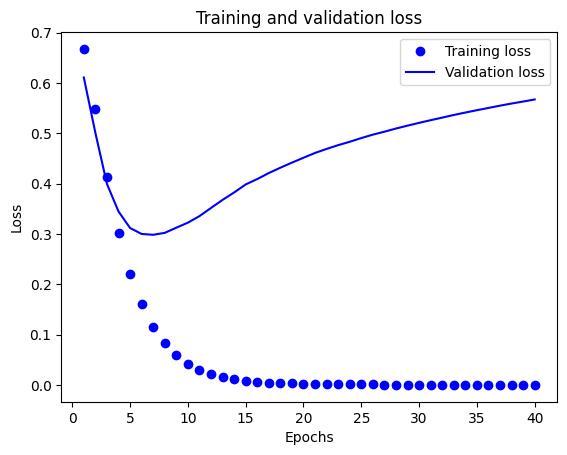

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

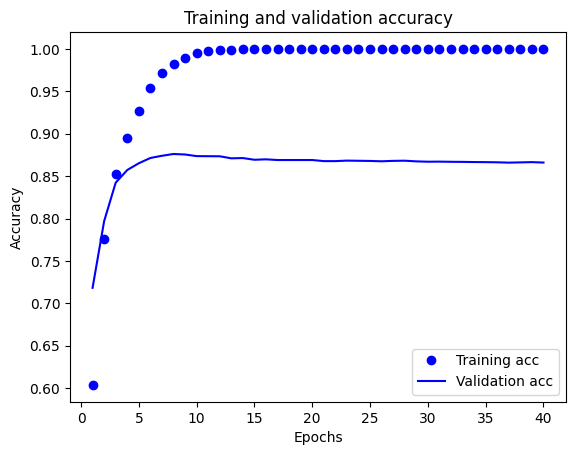

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.